### Notebook for modeling SERCA function 

In [5]:
# DO NOT DELETE
# WARNING: parameters deviate from sercamodelcompare.py impolementation 

Below are parameters consistent with Inesi's four-state SERCA model 

In [7]:
## derive Inesi model for P4
# baserd on  Kinetic and Equilibrium Characterization of an
# Energy-Transducing Enzyme and Its Partial Reactions
matplotlib.rcParams['figure.figsize'] = (6,3.75)
rcParams['savefig.dpi'] = 120


import numpy as np
import sympy as sp
M_to_uM = 1e6

## compare model w Fig 8 
#parameters are from pg 167
#EpCa2eqs = EpCa2eq.subs({\
#  Et: 1.,     # assume Et is fixed?? 
#  k1: 4.25e7, # 1/M sec (Af)
#  kn1: 450,   # 1/sec
#  k2: 15,     # 1/sec (Bf) 
#  kn2: 33,    # 1/sec
#  k3: 1e8,    # 1/M sec (Cf) 
#  kn3: 16     # 1/sec
#  })
#EpCa2func = sp.solve(EpCa2eqs,EpCa2)[0]

# Inesi
class paramsInesi:
    k1= 4.25e7 # 1/M sec (Af)
    kn1= 450.  # 1/sec
    k2= 15.    # 1/sec (Bf) 
    kn2= 33.   # 1/sec
    k3= 1e8    # 1/M sec (Cf) 
    kn3= 16.   # 1/sec
    K1 = kn1/k1
    K2 = kn2/k2
    K3 = kn3/k3

# Trieber
# Not quite sure why Af, Cf are in units 1/s and order of Mag lower
# since the rxns should still be Ca-dependent
class paramsTrieber:
    k1= 2.16e6 # 1/sec (Af)
    kn1= 400.  # 1/sec
    k2= 30.    # 1/sec (Bf) 
    kn2= 40.   # 1/sec
    k3= 2.57e7 # 1/sec (Cf) 
    kn3= 16.   # 1/sec
    K1 = kn1/k1
    K2 = kn2/k2
    K3 = kn3/k3

class paramsTrieberPLB:
    k1= 2.16e6 # 1/sec (Af)
    kn1= 400.  # 1/sec
    k2= 44.    # 1/sec (Bf) 
    kn2= 50.9e3# 1/sec
    k3= 404e3  # 1/sec (Cf) 
    kn3= 16.   # 1/sec
    K1 = kn1/k1
    K2 = kn2/k2
    K3 = kn3/k3

# from Fig 10? of Cantilina paper from which Trieber model is derived     
class paramsCantilina:
    # Cantilina
    k1= 100000000.0 # 1/sec (Af)
    kn1= 400.  # 1/sec
    k2= 30.    # 1/sec (Bf) 
    kn2= 40.   # 1/sec
    k3= 400000000.0 # 1/sec (Cf) 
    kn3= 16.   # 1/sec

    K1 = kn1/k1
    K2 = kn2/k2
    K3 = kn3/k3        
    
class paramsSS:            
    K1 = paramsCantilina.kn1/paramsCantilina.k1
    K2 = paramsCantilina.kn2/paramsCantilina.k2
    K3 = paramsCantilina.kn3/paramsCantilina.k3
    


This routine allows me to pass in some arbitrary function describing SERCA Ca binding, then evaluate the calcium saturation of the pump with respect to free calcium concentration

In [8]:
# Test
def doKin(dfunc,p,cs):
  cEpCa = dfunc(cs,p)
  #KCa = cs[np.argmin(np.abs(cEpCa-0.5))] * M_to_uM
  KCa = np.interp(0.5,cEpCa,cs)*M_to_uM
  return (cEpCa,KCa)


Here we are evaluating the pump saturation given different proposed parameters for the transition rates between SERCA states. Note that this function calls the sercaInesi.py module, wherein the lumped serca model is defined and solved

In [9]:

def doit(fileIn): 

  cs = np.linspace(-8,-4,30)
  cs = 10**cs
  
  import sercaInesi as sI
  vfunc = sI.Inesi()
  vfuncSS = sI.InesiSS()
  
  
  ## compare models 
  (valsInesi, KCaInesi) = doKin(vfunc,paramsInesi,cs)
  (valsTrieber, KCaTrieber) = doKin(vfunc,paramsTrieber,cs)
  (valsTrieberSS, KCaCantilinaSS) = doKin(vfuncSS,paramsCantilina,cs)
  (valsTrieberPLB, KCaTrieberPLB) = doKin(vfunc,paramsTrieberPLB,cs)
  (valsCantilina, KCaCantilina) = doKin(vfunc,paramsCantilina,cs)
  
  import matplotlib.pyplot as plt
  plt.figure()
  plt.plot(cs,valsInesi,label="Inesi")
  plt.plot(cs,valsTrieber,label="Trieber")
  plt.plot(cs,valsTrieberSS,"r.",label="CantilinaSS")
  plt.plot(cs,valsCantilina,label="Cantilina")
  plt.title("SERCA models")         
  plt.xscale('log')
  plt.xlabel('pCa')        
  plt.ylabel('Saturation') 
  plt.legend(loc=0)
  plt.gcf().savefig("130823_sercaModelsCompare.png")

  
  ## compare param perturb
  p = paramsSS(); 
  s=2.  
  (valsSS1, KCaSS1) = doKin(vfuncSS,p,cs)
  print  "K2 %f KCa50 %f" % (p.K2, KCaSS1)
  p = paramsSS(); p.K2 *= 1/s
  (valsSS2, KCaSS2) = doKin(vfuncSS,p,cs)
  print  "K2 %f KCa50 %f" % (p.K2, KCaSS2)
  p = paramsSS(); p.K2 *= s
  (valsSS3, KCaSS3) = doKin(vfuncSS,p,cs)
  print  "K2 %f KCa50 %f" % (p.K2, KCaSS3)  
  p = paramsSS(); p.K3 *= 1/s
  (valsSS4, KCaSS4) = doKin(vfuncSS,p,cs)
  p = paramsSS(); p.K3 *= s
  (valsSS5, KCaSS5) = doKin(vfuncSS,p,cs)
  p = paramsSS(); p.K1 *= 1/s 
  (valsSS6, KCaSS6) = doKin(vfuncSS,p,cs)
  p = paramsSS(); p.K1 *= s
  (valsSS7, KCaSS7) = doKin(vfuncSS,p,cs)
  
  
  
  import matplotlib.pyplot as plt
  plt.figure()
  plt.plot(cs,valsSS1,"k-",label="control")
  plt.plot(cs,valsSS6,"g-",label="%3.1f K1" % (1/s))
  plt.plot(cs,valsSS7,"g-.",label="%3.1f K1"% (s))
  plt.plot(cs,valsSS2,"b-",label="%3.1f K2"% (1/s))
  plt.plot(cs,valsSS3,"b-.",label="%3.1f. K2"% (s))
  plt.plot(cs,valsSS4,"r-",label="%3.1f K3"% (1/s))
  plt.plot(cs,valsSS5,"r-.",label="%3.1f K3"% (s))
  plt.title("SERCA models")         
  plt.xscale('log')
  #plt.xlim([10**-7, 10**-5])
  plt.xlabel('pCa')        
  plt.ylabel('Saturation') 
  plt.legend(loc=0)
  plt.gcf().savefig("130823_sercaPLBregulation.png")
  


Ca**2*Et/(Ca**2 + Ca*K2*K3 + Ca*K3 + K1*K2*K3)
KCa Cant  0.514796700424
KCa CantPLBHack  0.73106063353
KCa TriebHack  0.514796700424
KCa TriebPLBHack  0.708142548908


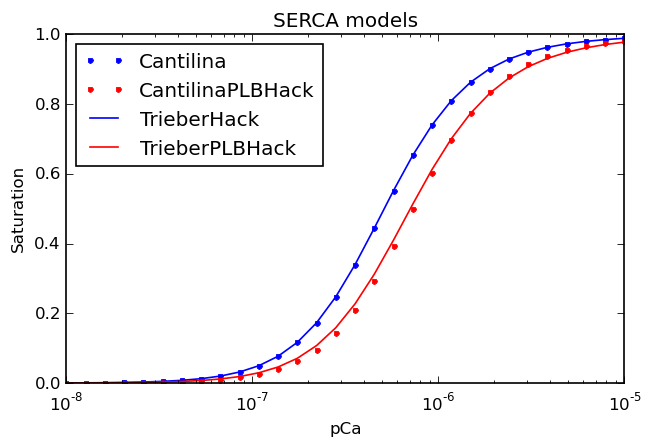

In [3]:
class paramsCantilina:
    # Cantilina
    k1= 100000000.0 # 1/sec (Af)
    kn1= 400.  # 1/sec
    k2= 30.    # 1/sec (Bf) 
    kn2= 40.   # 1/sec
    k3= 400000000.0 # 1/sec (Cf) 
    kn3= 16.   # 1/sec

    K1 = kn1/k1
    K2 = kn2/k2
    K3 = kn3/k3    
    
sk1 = 100000000.0/216000.  # Af: Cantilina/Trieber
sk3 = 400000000.0/2567000. #Cf: Cantilina/Trieber
    
class paramsTrieberHack:    
    # Trieber
    k1= 216000.*sk1 # 1/sec (Af)
    kn1= 400.  # 1/sec
    k2= 30.    # 1/sec (Bf) 
    kn2= 40.   # 1/sec
    k3= 2567000.*sk3 # 1/sec (Cf) 
    kn3= 16.   # 1/sec
    
    
    K1 = kn1/k1
    K2 = kn2/k2
    K3 = kn3/k3
    
class paramsTrieberPLBHack:    
    # Trieber
    k1= 216000.*sk1 # 1/sec (Af)
    kn1= 400.  # 1/sec
    k2= 44.    # 1/sec (Bf) 
    kn2= 50900.   # 1/sec
    k3= 404000.*sk3 # 1/sec (Cf) 
    kn3= 16.   # 1/sec
    
    
    kn2=40.
    k3= 0.4*2567000.*sk3
    
    K1 = kn1/k1
    K2 = kn2/k2
    K3 = kn3/k3

    
if(1):
  cs = np.linspace(-8,-5,30)
  cs = 10**cs
  
  import sercaInesi as sI
  vfunc = sI.Inesi()
  vfuncSS = sI.InesiSS()
  
  pc =paramsCantilina()   
  pc.kn2 *= 2; pc.K2 = pc.kn2/pc.k2
  paramsCantilinaPLBHack=pc  
  
  ## compare models 
  #(valsInesi, KCaInesi) = doKin(vfunc,paramsInesi,cs)
  #print KCaInesi
  (valsCantilina, KCaCantilina) = doKin(vfunc,paramsCantilina,cs)
  print "KCa Cant ", KCaCantilina  
  (valsCantilinaPLBHack, KCaCantilinaPLBHack) = doKin(vfunc,paramsCantilinaPLBHack,cs)
  print "KCa CantPLBHack ", KCaCantilinaPLBHack  
  (valsTrieberHack, KCaTrieberHack) = doKin(vfunc,paramsTrieberHack,cs)
  print "KCa TriebHack ", KCaTrieberHack 
  (valsTrieberPLBHack, KCaTrieberPLBHack) = doKin(vfunc,paramsTrieberPLBHack,cs)
  print "KCa TriebPLBHack ", KCaTrieberPLBHack 
    
  plt.figure()
  #plt.plot(cs,valsInesi,label="Inesi")
  plt.plot(cs,valsCantilina,'b.',label="Cantilina")
  plt.plot(cs,valsCantilinaPLBHack,'r.',label="CantilinaPLBHack")  
  plt.plot(cs,valsTrieberHack,'b-',label="TrieberHack")  
  #plt.plot(cs,valsTrieberSS,"g.",label="TrieberSS")
  plt.plot(cs,valsTrieberPLBHack,'r-',label="TrieberPLBHack")
  plt.title("SERCA models")         
  plt.xscale('log')
  #plt.xlim([0,1e-5])  
  plt.xlabel('pCa')        
  plt.ylabel('Saturation') 
  plt.legend(loc=0)    

Here was evaluating the corresponding free energy difference between states that are in rapid equilibrium (e.g. $\Delta G = -kT\; log K_i$)

In [10]:
class empty:pass

# Assembling free energy surface
# add notes here on math (1) 
kT = 0.59 # [kcal/mol]
nStates = 4
def FreeEnergySurf(params):
  dG10 = kT * np.log(params.K1)
  print dG10
  dG21 = kT * np.log(params.K2)
  print dG21
  dG32 = kT * np.log(params.K3)
  print dG32
  print ""
  
  inds = np.arange(nStates)
  Gs=np.zeros(nStates)
  Gs[1]= Gs[0]+dG10
  Gs[2]= Gs[1]+dG21
  Gs[3]= Gs[2]+dG32

  # make UNREALISTIC barriers
  pkg = empty()
  pkg.inds = inds  
  pkg.Gs = Gs  
  pkg.indsTS = np.array([0.5,1.5,2.5])
  pkg.GTSs = np.array([1,6,-5])
  return pkg

pCantilina = FreeEnergySurf(paramsCantilina)
pCantilinaPLBHack = FreeEnergySurf(paramsCantilinaPLBHack)
ps = [pCantilina,pCantilinaPLBHack]

-7.33323755614
0.169732422747
-10.0502879659

-7.33323755614
0.578689259277
-10.0502879659



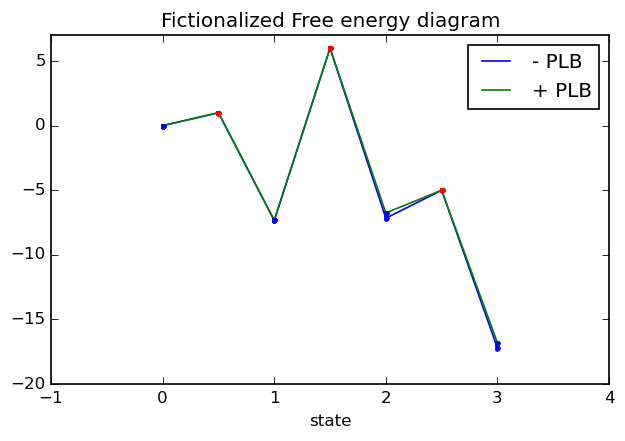

In [5]:
from scipy.interpolate import interp1d
labels=(["- PLB", "+ PLB"])

for i,p in enumerate(ps):
  indsTot = np.linspace(0,3,7)
  Gs = p.Gs  
  GTSs = p.GTSs  
  GsTot = np.array([Gs[0],GTSs[0],Gs[1],GTSs[1],Gs[2],GTSs[2],Gs[3]])
  #indsSmooth = np.linspace(0,nStates-1,100)
  #GsSmooth = interp1d(indsTot, GsTot, kind='cubic')
  #plot(indsSmooth,GsSmooth(indsSmooth))
  plt.plot(indsTot,GsTot,label=labels[i])
  title("Fictionalized Free energy diagram")
  plt.plot(p.inds,p.Gs,'b.') # label="WT, -PLB")
  plt.plot(p.indsTS,p.GTSs,'r.') # Barriers



plt.xlim([-1,4])
plt.ylim([-20,7])
plt.xlabel("state") 
legend()

## The rest is goofing around. Don't delete, as it was useful at some point 

In [6]:
(kT*(np.log(paramsCantilina.kn1)+np.log(paramsCantilina.k1))+(Gs[0]+Gs[1])) / 2.

3.5349640827937097

## Maxima code for determining barrier height
# Arrhenius rate equation (ignoring prefactor) 
kn1:exp(-B*(Gs-G1));  #k^{-1}, 1-->0; Gs, Gi - Free energies of transition state and state i
k1:exp(-B*(Gs-G0));  #k^{-1}, 1-->0

# log(kn1)+log(k1) = ...
RHS:log(kn1)+log(k1); # assume we know values of Gi
# but, need to have Arrhenius parameter A>>kn1,kn, s.t
# RHS= 2*ln(A) + [- B (Gs - G1) - B (Gs - G0)]
# so we move 2ln(A) to LHS
LHS:Logkn1+Logk1-2*LogA;    # assume we know values of kn1,kn

    
expand(solve(LHS=RHS,Gs));

                          G1   G0   Logkn1   Logk1   LogA
(%o50)              [Gs = -- + -- - ------ - ----- + ----]
                          2    2     2 B      2 B     B

In [7]:
Gs[1]+Gs[0] - kT*(np.log(paramsCantilina.kn1)+np.log(paramsCantilina.k1))

-21.73640327786379

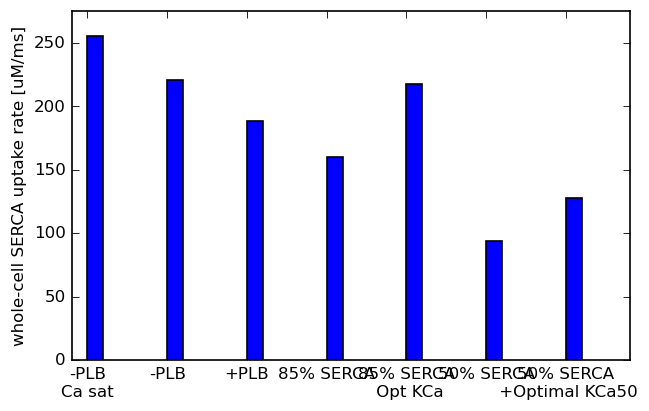

In [8]:
# rho  pump density [n/m^2]
# KCa50 binding constant [uM]
def HillModel(rho,KCa50,Ca=1.):
    Vmax=256. # uM/ms (guess, but double check)
    Vol = 1. # m^3 (for unit consistency)
    V = rho*Vmax/(1+(KCa50/Ca)**2) * Vol
    #print KCa50
    return V

n=7
rhos = [1.,1.,1.,0.85,0.85,0.5,0.5]
KCas = [0.4,.4,0.6,0.6,1e-9,0.6,1e-9] # uM [-PLB,+PLB,red expr,hyper]
vs = np.zeros(n)
i=0
vs[i] = HillModel(rhos[i],KCas[i],Ca=10.);i+=1;
vs[i] = HillModel(rhos[i],KCas[i],Ca=1.);i+=1;
vs[i] = HillModel(rhos[i],KCas[i],Ca=1.);i+=1;
vs[i] = HillModel(rhos[i],KCas[i],Ca=1.);i+=1;
vs[i] = HillModel(rhos[i],KCas[i],Ca=1.);i+=1;
vs[i] = HillModel(rhos[i],KCas[i],Ca=1.);i+=1;
vs[i] = HillModel(rhos[i],KCas[i],Ca=1.);i+=1;
fig, ax = plt.subplots()
width=0.2
ind=np.arange(n)
ax.bar(ind+width,vs,width)
ax.set_ylim([0,275])
ax.set_ylabel("whole-cell SERCA uptake rate [uM/ms]")
ax.set_xticks(ind+width)
ax.set_xticklabels( ('-PLB\nCa sat','-PLB','+PLB', '85% SERCA','85% SERCA\n Opt KCa','50% SERCA', '50% SERCA\n +Optimal KCa50'))
plt.gcf().savefig("130823_plbcases.png")

In [9]:
vs[1]/vs[0]

0.86344827586206896

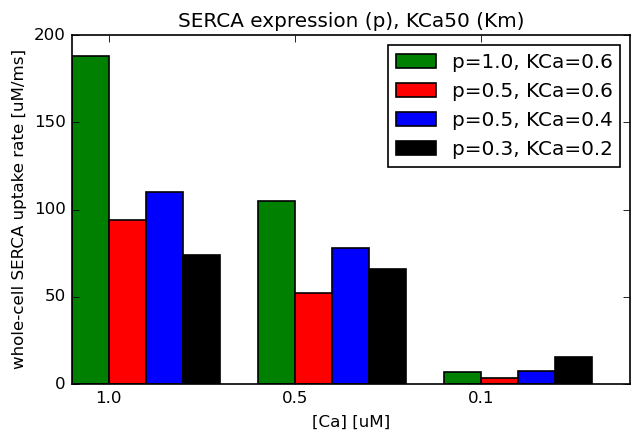

In [10]:

cas = [1.0,0.5,0.1] # Ca2+, [uM] 
n = np.shape(cas)[0]
normal=np.zeros(3)
reduced=np.zeros(3)
modplb = np.zeros(3)
lowplb = np.zeros(3)

rhos = [1.,0.5,0.5,0.3]
KCas = [0.6,.6,0.4,0.2]
col = ['g','r','b','k']


for i,ca in enumerate(cas):
  normal[i] = HillModel(rhos[0],KCas[0],Ca=ca)
  reduced[i] = HillModel(rhos[1],KCas[1],Ca=ca)
  modplb[i] = HillModel(rhos[2],KCas[2],Ca=ca)
  lowplb[i] = HillModel(rhos[3],KCas[3],Ca=ca)
    
fig, ax = plt.subplots()
width=0.2
ind=np.arange(n)
l0 = ax.bar(ind,normal,width, color=col[0])
l1 = ax.bar(ind+width,reduced,width,color=col[1])
l2 = ax.bar(ind+2*width,modplb,width,color=col[2])
l3 = ax.bar(ind+3*width,lowplb,width,color=col[3])
ax.set_ylabel("whole-cell SERCA uptake rate [uM/ms]")
ax.set_xlabel("[Ca] [uM]")
ax.set_xticks(ind+width)
ls = []
for i, rho in enumerate(rhos):
    ls.append('p=%3.1f, KCa=%3.1f'%(rhos[i],KCas[i]))
    
ax.legend((l0[0],l1[0],l2[0],l3[0]),ls)
labs = (cas[0],cas[1],cas[2])
ax.set_xticklabels( (cas))
plt.title("SERCA expression (p), KCa50 (Km)") 
plt.gcf().savefig("130823_plbcases_Ca.png")

[0.2, 0.6, 0.8]
0.8
[0.2, 0.6, 0.8]
0.2
0
0.6
1
0.8
2
[0.6, 0.6, 0.4, 0.2]
0.2
[0.6, 0.6, 0.4, 0.2]
0.6
0
0.6
1
0.4
2
0.2
3


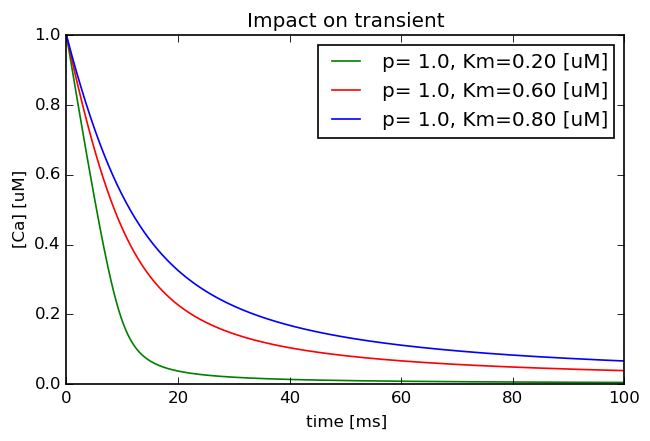

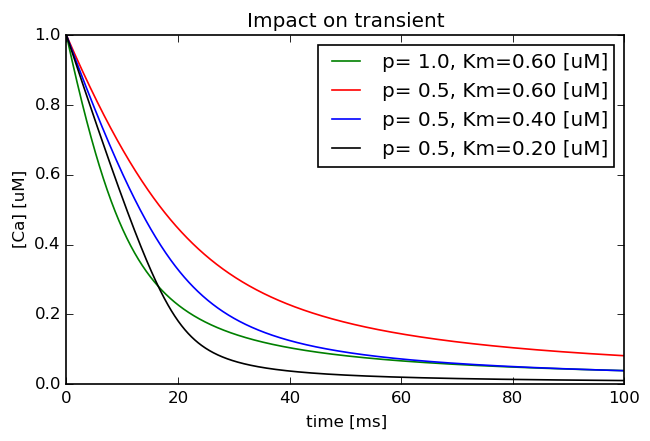

In [11]:
from scipy.integrate import odeint
Km = 1.
rho =1.
# params[0] - rho, [arams[1]=Km
def deriv(ca,t,params): # return derivatives of the array y
    Vmax=256. # uM/ms (guess, but double check)
    Vol = 1. # m^3 (for unit consistency)
    
    Vmax=0.1
    #V = -rho*Vmax/(1+(Km/ca)**2) * Vol
    V = -params[0]*Vmax/(1+(params[1]/ca)**2) * Vol
    return V

# Init conds
times = linspace(0.0,100.0,1000)
yinit = array([1.0]) # initial values

# solves
class empty:pass
#Kms = [0.4,0.6]
#for i,Km in enumerate(Kms):
#  sol = empty()
#  sol.ys = odeint(deriv,yinit,times)
#  sol.Km = Km
#  sols.append(sol)  


#for i,sol in enumerate(sols):    
#  plot(times,sol.ys[:,0],label="Km=%4.2f"%sol.Km) # y[:,0] corresponds to 'y', and y[:,1] s.b. 'dy/dt'
def dafunc(rho="single",name="blank.png"):
  sols=[]
  
  if(rho=="single"):
    rhos=[1.,1.,1.]
    #KCas=[0.57,0.6,0.63]
    KCas=[0.20,0.6,0.8]
  else:  
    rhos = [1.,0.5,0.5,0.5]
    KCas = [0.6,.6,0.4,0.2]
  
  print KCas    
  col = ['g','r','b','k']
  n = np.shape(rhos)[0]
  for i in range(n):
   sol = empty()
   rho = rhos[i]
   Km = KCas[i] 
   params=[rho,Km]     
   sol.ys = odeint(deriv,yinit,times,args=(params,))
   sols.append(sol)    
        
  print Km
  print KCas  
  plt.figure()  
  for i,sol in enumerate(sols):    
    print KCas[i]    
    print i
    plot(times,sol.ys[:,0],col[i],label="p= %3.1f, Km=%4.2f [uM]"%\
         (rhos[i],KCas[i])) 
 
    
  plt.title("Impact on transient")     
  plt.ylabel("[Ca] [uM]")
  plt.xlabel("time [ms]") 
  plt.legend()
      
  plt.gcf().savefig(name)
        
dafunc(rho="single",name="plb_single.png") 
dafunc(rho="several",name="130823_plbcases_transients.png")